In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_I"
plane = "V"

In [3]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -20 and x - mu_x[0] < 20:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    emittance_wire = ((sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    norm_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", emittance_wire, np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity)
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(emittance_wire), np.std(emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
        sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [4]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results")

result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
# result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
# result_folders.remove('tomoscope')

print(result_folders)

['PROFILE_TEST_730_WS_V_R3_2018_10_12_18_14', 'PROFILE_TEST_325_WS_V_R3_2018_10_12_18_49', 'PROFILE_TEST_310_WS_V_R3_2018_10_12_19_35', 'PROFILE_TEST_350_WS_V_R3_2018_10_12_17_23', 'PROFILE_TEST_285_WS_V_R3_2018_10_12_18_36', 'PROFILE_TEST_375_WS_V_R3_2018_10_12_18_58', 'PROFILE_TEST_450_WS_V_R3_2018_10_12_17_45', 'PROFILE_TEST_375_WS_V_R3_2018_10_12_17_28', 'PROFILE_TEST_400_WS_V_R3_2018_10_12_17_34', 'PROFILE_TEST_550_WS_V_R3_2018_10_12_17_57', 'PROFILE_TEST_300_WS_V_R3_2018_10_12_19_26', 'PROFILE_TEST_470_WS_V_R3_2018_10_12_20_13', 'PROFILE_TEST_340_WS_V_R3_2018_10_12_20_21', 'PROFILE_TEST_360_WS_V_R3_2018_10_12_19_55', 'PROFILE_TEST_600_WS_V_R3_2018_10_12_18_01', 'PROFILE_TEST_795_WS_V_R3_2018_10_12_18_29', 'PROFILE_TEST_430_WS_V_R3_2018_10_12_20_02', 'PROFILE_TEST_320_WS_V_R3_2018_10_12_19_44', 'PROFILE_TEST_675_WS_V_R3_2018_10_12_18_08', 'PROFILE_TEST_500_WS_V_R3_2018_10_12_17_51', 'PROFILE_TEST_285_WS_V_R3_2018_10_12_16_43', 'PROFILE_TEST_325_WS_V_R3_2018_10_12_17_16']



PROFILE_TEST_730_WS_V_R3_2018_10_12_18_14


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


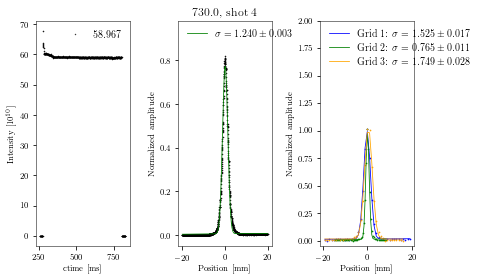

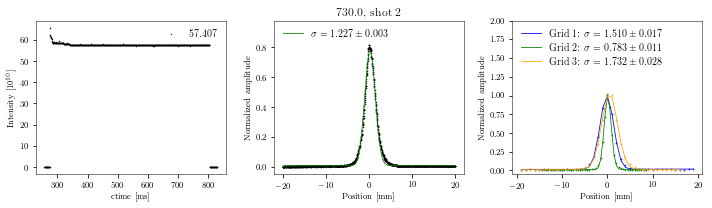

Recorded intensities: [ 58.967  57.407]
Intensities after outlier exclusion: [0, 57.407000000000004]
Beta wire: 4.2751192354
Beta rel: 0.91195 Gamma rel: 2.43728
0.799473995856 0
An intensity value was excluded.
0.782532070463 57.407

Normal emittance: [ 0.799474    0.78253207] 0.791003033159 0.00847096269672
Normalized emittance: [0.39126603523127862] 0.391266035231 0.0
Intensity: [ 58.967  57.407]

Outliers excluded: [] nan nan

PROFILE_TEST_325_WS_V_R3_2018_10_12_18_49


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


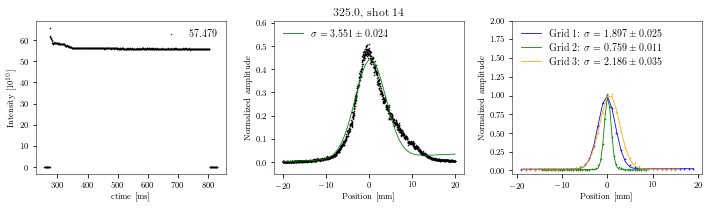

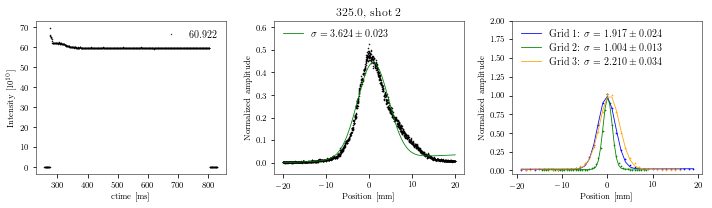

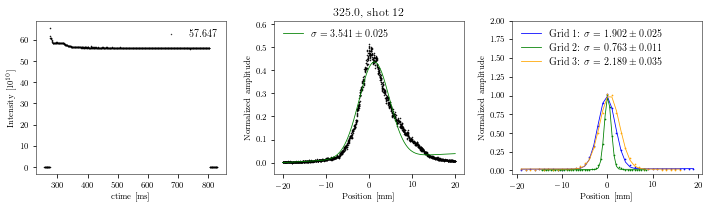

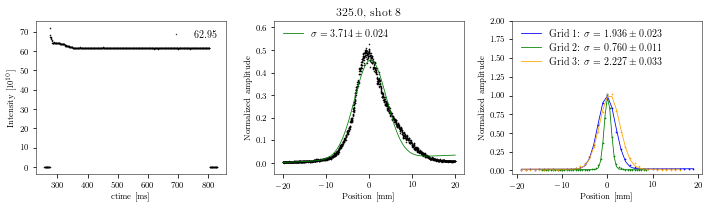

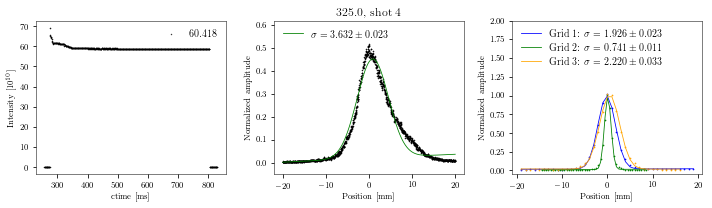

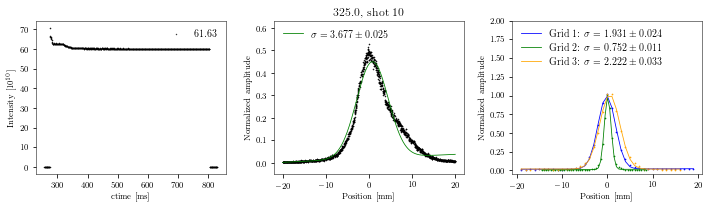

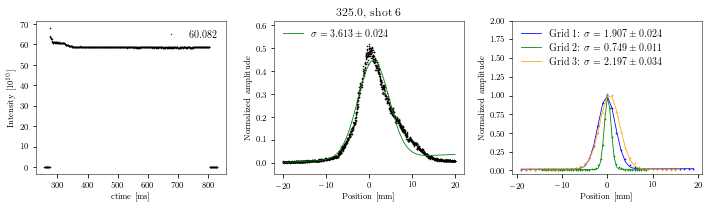

Recorded intensities: [ 57.479  60.922  57.647  62.95   60.418  61.63   60.082]
Intensities after outlier exclusion: [0, 60.922000000000004, 0, 0, 60.417999999999999, 61.630000000000003, 60.082000000000001]
Beta wire: 3.9867574309
Beta rel: 0.38404 Gamma rel: 1.08305
1.3151774005 0
An intensity value was excluded.
1.37039877174 60.922
1.30812473969 0
An intensity value was excluded.
1.43907761865 0
An intensity value was excluded.
1.37592644115 60.418
1.41068853315 61.63
1.36213150401 60.082

Normal emittance: [ 1.3151774   1.37039877  1.30812474  1.43907762  1.37592644  1.41068853
  1.3621315 ] 1.36878928698 0.0436680228776
Normalized emittance: [0.78104124306215739, 0.79073330410954146, 0.7947675514242255, 0.78718319799272185] 0.788431324147 0.00504028781902
Intensity: [ 57.479  60.922  57.647  62.95   60.418  61.63   60.082]

Outliers excluded: [0.78104124306215739, 0.79073330410954146, 0.7947675514242255, 0.78718319799272185] 0.788431324147 0.00504028781902

PROFILE_TEST_310_WS_V_R

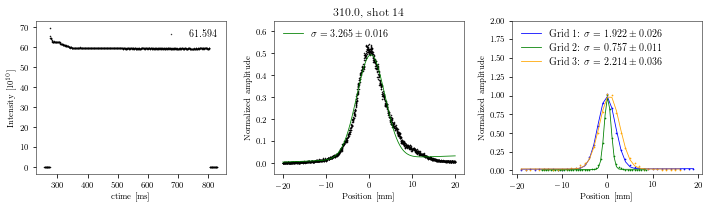

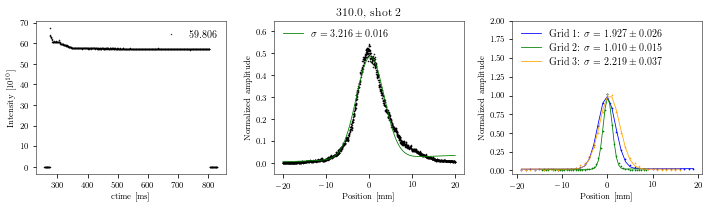

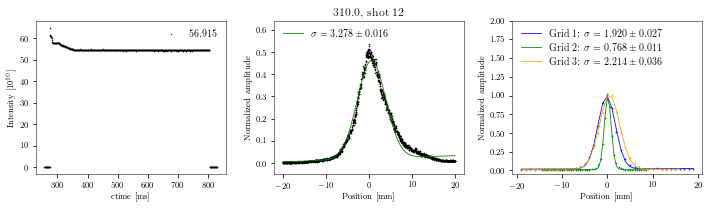

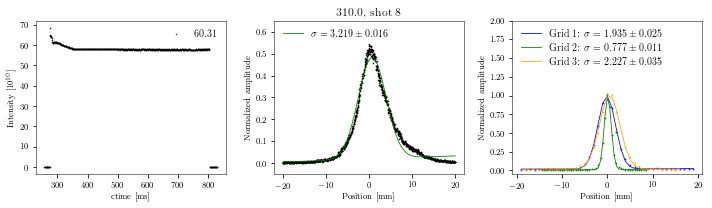

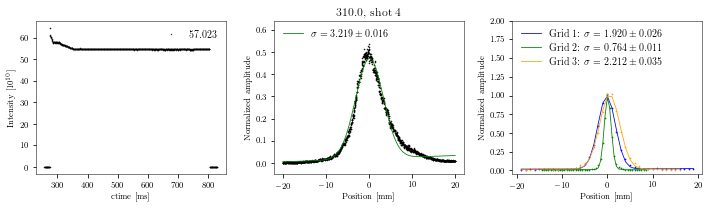

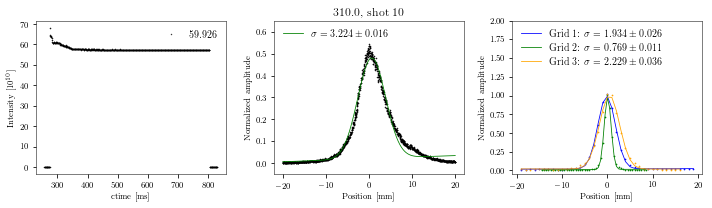

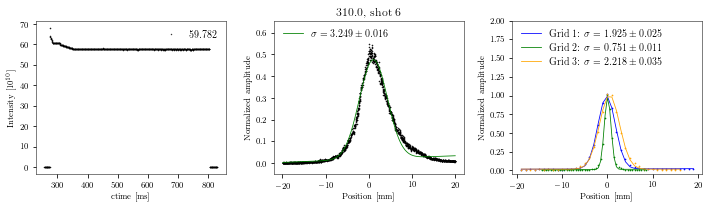

Recorded intensities: [ 61.594  59.806  56.915  60.31   57.023  59.926  59.782]
Intensities after outlier exclusion: [0, 59.806000000000004, 0, 60.310000000000002, 0, 59.926000000000002, 59.782000000000004]
Beta wire: 3.9443380379
Beta rel: 0.35976 Gamma rel: 1.07176
1.04194126659 0
An intensity value was excluded.
1.01119501581 59.806
1.05032169585 0
An intensity value was excluded.
1.01262034192 60.31
1.01299450517 0
An intensity value was excluded.
1.01620582016 59.926
1.03208891585 59.782

Normal emittance: [ 1.04194127  1.01119502  1.0503217   1.01262034  1.01299451  1.01620582
  1.03208892] 1.02533822305 0.0148465955053
Normalized emittance: [0.57927497353489732, 0.57524376644619601, 0.58097974314699574, 0.5914816503629553] 0.581745033373 0.0059948946362
Intensity: [ 61.594  59.806  56.915  60.31   57.023  59.926  59.782]

Outliers excluded: [0.57927497353489732, 0.57524376644619601, 0.58097974314699574, 0.5914816503629553] 0.581745033373 0.0059948946362

PROFILE_TEST_350_WS_V_R3

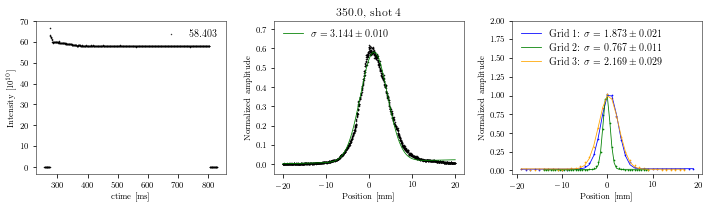

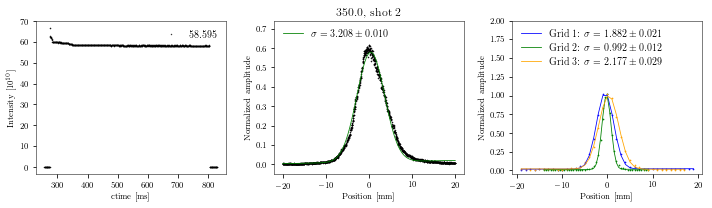

Recorded intensities: [ 58.403  58.595]
Intensities after outlier exclusion: [58.402999999999999, 0]
Beta wire: 4.04919100465
Beta rel: 0.4273 Gamma rel: 1.10606
1.15384135411 58.403
1.20115828927 0
An intensity value was excluded.

Normal emittance: [ 1.15384135  1.20115829] 1.17749982169 0.0236584675813
Normalized emittance: [0.57692067705403549] 0.576920677054 0.0
Intensity: [ 58.403  58.595]

Outliers excluded: [] nan nan

PROFILE_TEST_285_WS_V_R3_2018_10_12_18_36


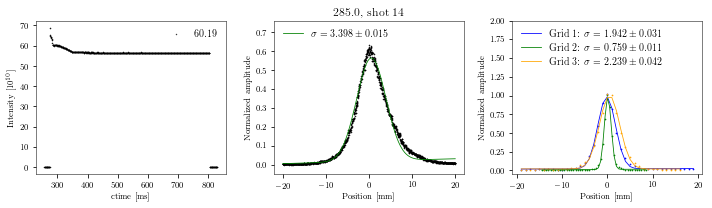

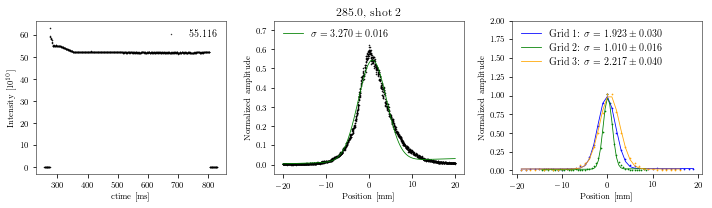

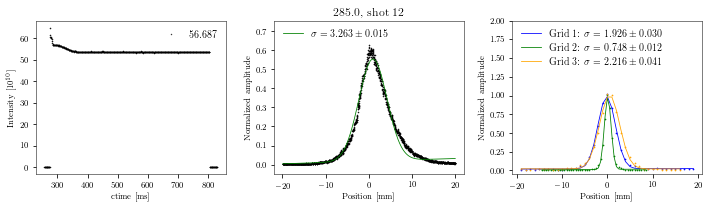

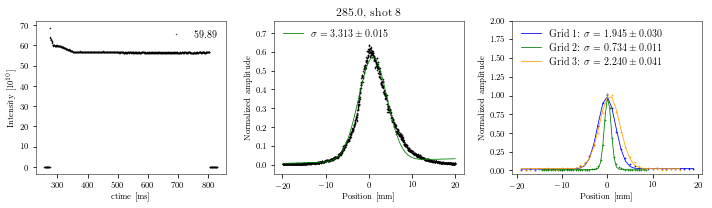

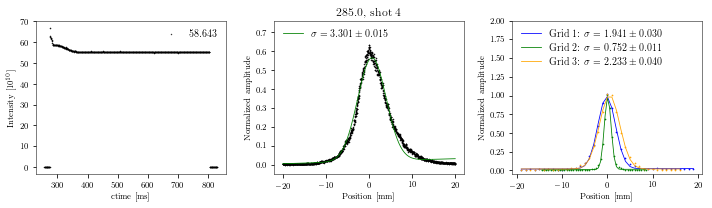

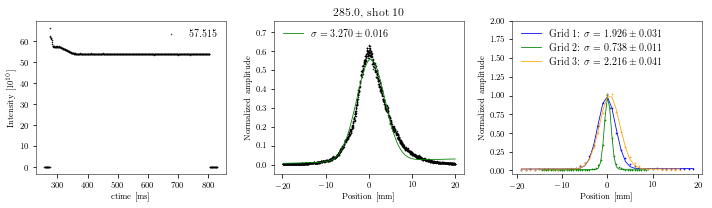

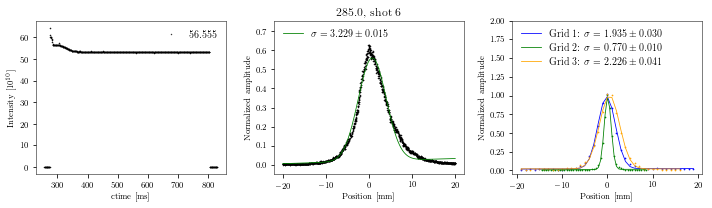

Recorded intensities: [ 60.19   55.116  56.687  59.89   58.643  57.515  56.555]
Intensities after outlier exclusion: [0, 0, 56.687000000000005, 0, 58.643000000000001, 57.515000000000001, 56.555]
Beta wire: 3.8624470797
Beta rel: 0.32403 Gamma rel: 1.05703
1.02366229817 0
An intensity value was excluded.
0.948473980334 0
An intensity value was excluded.
0.944056029898 56.687
0.973042087804 0
An intensity value was excluded.
0.96646351899 58.643
0.948254461531 57.515
0.924598341179 56.555

Normal emittance: [ 1.0236623   0.94847398  0.94405603  0.97304209  0.96646352  0.94825446
  0.92459834] 0.961221531129 0.0293564565916
Normalized emittance: [0.54577001342890563, 0.54008816362509693, 0.5403051960982419, 0.53576887092553249] 0.540483061019 0.00354834587885
Intensity: [ 60.19   55.116  56.687  59.89   58.643  57.515  56.555]

Outliers excluded: [0.54577001342890563, 0.54008816362509693, 0.5403051960982419, 0.53576887092553249] 0.540483061019 0.00354834587885

PROFILE_TEST_375_WS_V_R3_20

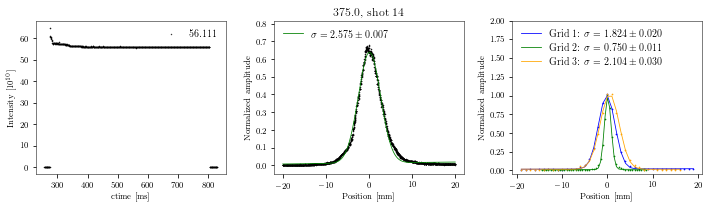

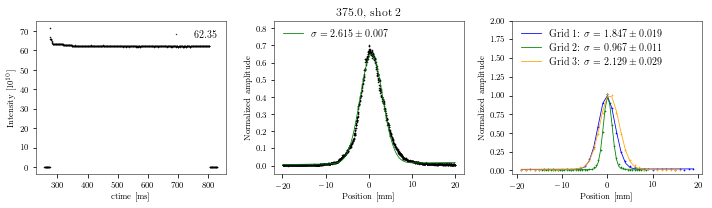

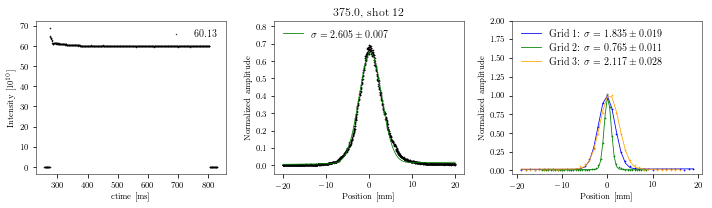

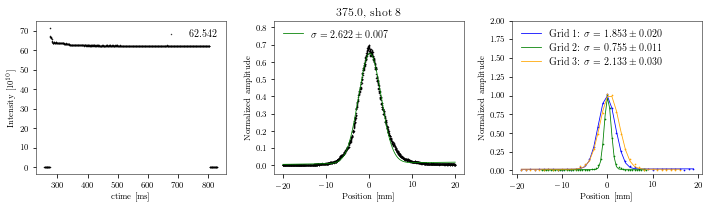

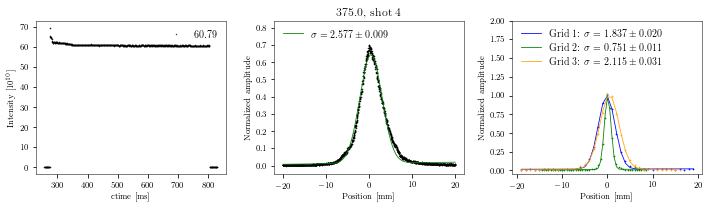

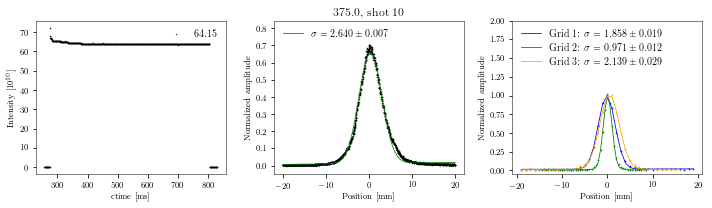

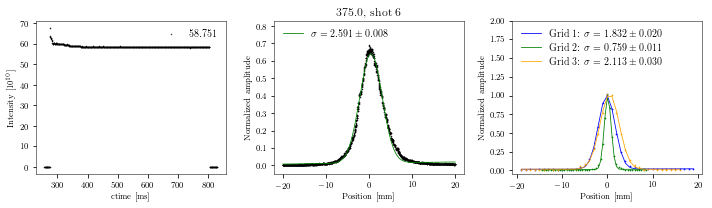

Recorded intensities: [ 56.111  62.35   60.13   62.542  60.79   64.15   58.751]
Intensities after outlier exclusion: [0, 62.350000000000001, 60.130000000000003, 62.542000000000002, 60.789999999999999, 0, 58.751000000000005]
Beta wire: 4.1050652748
Beta rel: 0.47317 Gamma rel: 1.13511
0.867366897096 0
An intensity value was excluded.
0.894434350998 62.35
0.887560071446 60.13
0.899807852465 62.542
0.868923162904 60.79
0.911913432592 0
An intensity value was excluded.
0.878275155102 58.751

Normal emittance: [ 0.8673669   0.89443435  0.88756007  0.89980785  0.86892316  0.91191343
  0.87827516] 0.886897274658 0.0152530244455
Normalized emittance: [0.62415307421925004, 0.6422227032853145, 0.62597518232393812, 0.62191113496927974, 0.65042082217037589] 0.632936583394 0.0113057709111
Intensity: [ 56.111  62.35   60.13   62.542  60.79   64.15   58.751]

Outliers excluded: [0.62415307421925004, 0.6422227032853145, 0.62597518232393812, 0.62191113496927974, 0.65042082217037589] 0.632936583394 0.01

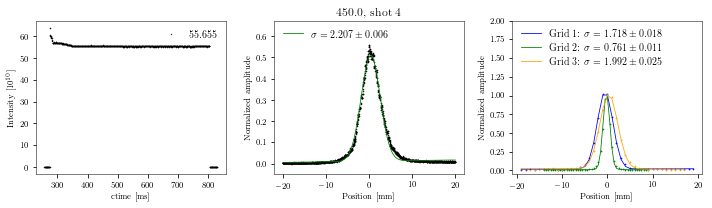

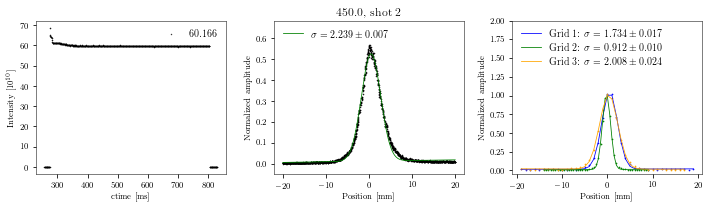

Recorded intensities: [ 55.655  60.166]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.2116465903
Beta rel: 0.62059 Gamma rel: 1.27529
0.915585530401 0
An intensity value was excluded.
0.941725119964 0
An intensity value was excluded.

Normal emittance: [ 0.91558553  0.94172512] 0.928655325182 0.0130697947812
Normalized emittance: [] nan nan
Intensity: [ 55.655  60.166]

Outliers excluded: [] nan nan

PROFILE_TEST_375_WS_V_R3_2018_10_12_17_28


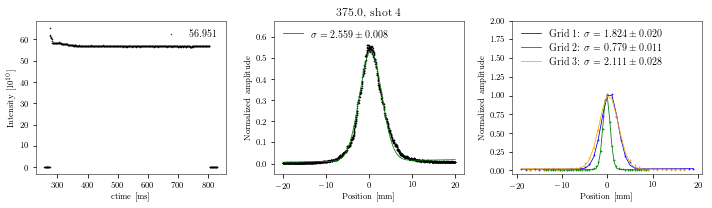

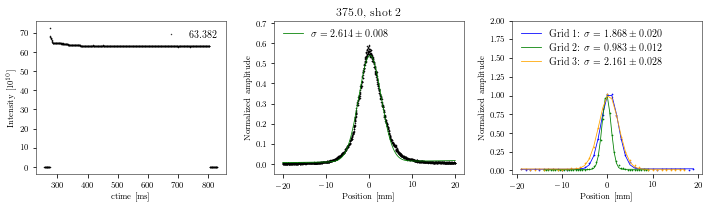

Recorded intensities: [ 56.951  63.382]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.1050652748
Beta rel: 0.47317 Gamma rel: 1.13511
0.857017653058 0
An intensity value was excluded.
0.89414593588 0
An intensity value was excluded.

Normal emittance: [ 0.85701765  0.89414594] 0.875581794469 0.0185641414107
Normalized emittance: [] nan nan
Intensity: [ 56.951  63.382]

Outliers excluded: [] nan nan

PROFILE_TEST_400_WS_V_R3_2018_10_12_17_34


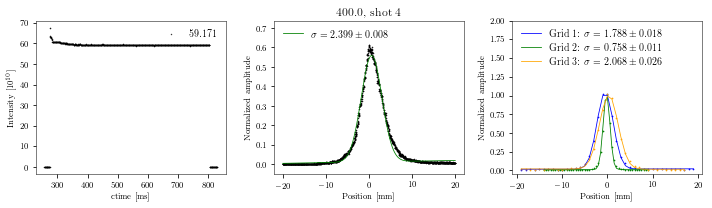

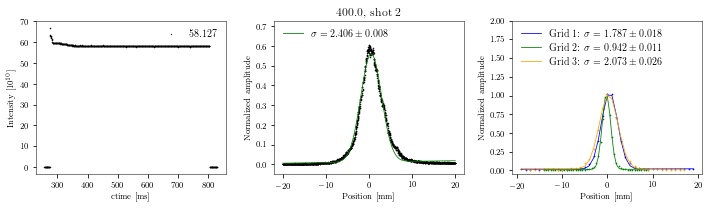

Recorded intensities: [ 59.171  58.127]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.15042926005
Beta rel: 0.52149 Gamma rel: 1.17198
0.847576535276 0
An intensity value was excluded.
0.852744045094 0
An intensity value was excluded.

Normal emittance: [ 0.84757654  0.85274405] 0.850160290185 0.00258375490884
Normalized emittance: [] nan nan
Intensity: [ 59.171  58.127]

Outliers excluded: [] nan nan

PROFILE_TEST_550_WS_V_R3_2018_10_12_17_57


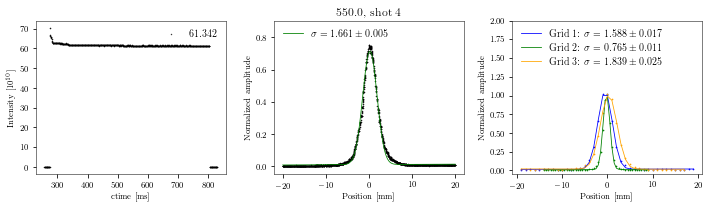

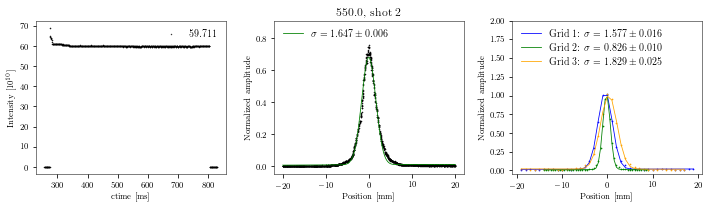

Recorded intensities: [ 61.342  59.711]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.247446705050001
Beta rel: 0.78965 Gamma rel: 1.62983
0.836133384534 0
An intensity value was excluded.
0.82153692254 0
An intensity value was excluded.

Normal emittance: [ 0.83613338  0.82153692] 0.828835153537 0.0072982309966
Normalized emittance: [] nan nan
Intensity: [ 61.342  59.711]

Outliers excluded: [] nan nan

PROFILE_TEST_300_WS_V_R3_2018_10_12_19_26


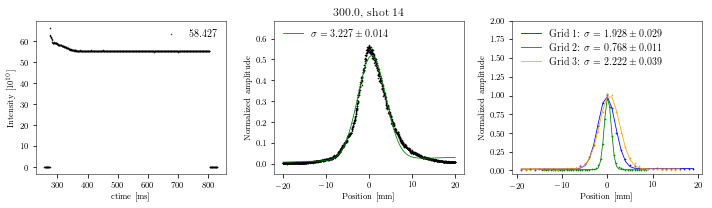

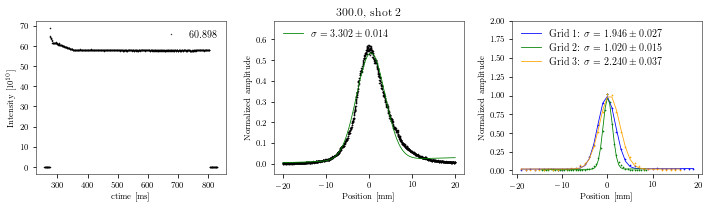

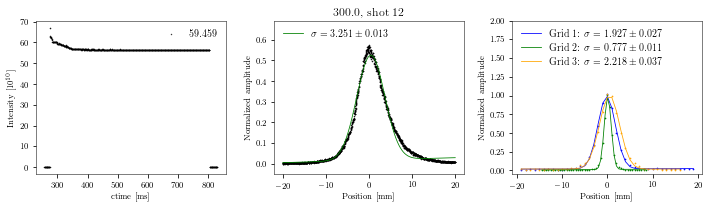

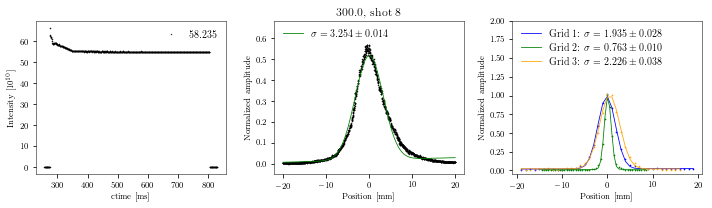

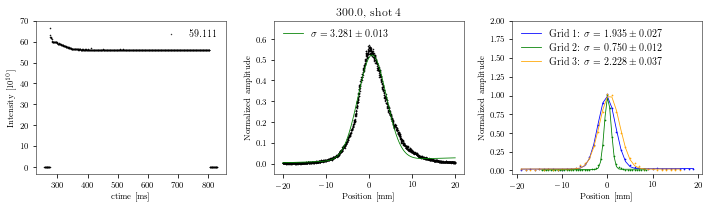

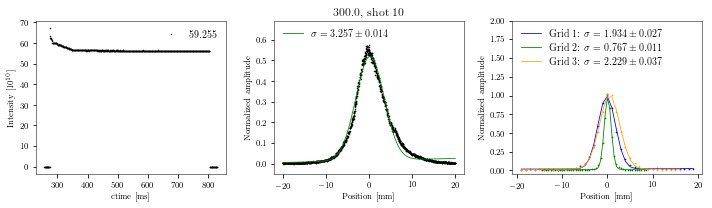

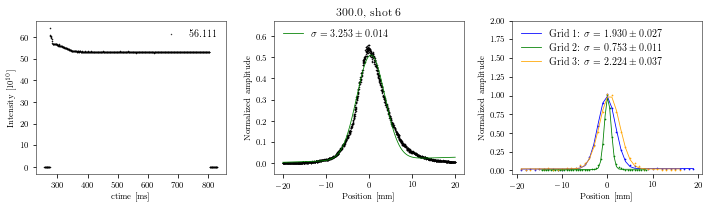

Recorded intensities: [ 58.427  60.898  59.459  58.235  59.111  59.255  56.111]
Intensities after outlier exclusion: [58.427, 0, 59.459000000000003, 58.234999999999999, 59.111000000000004, 59.255000000000003, 0]
Beta wire: 3.91303694025
Beta rel: 0.34446 Gamma rel: 1.06519
0.976582003342 58.427
1.0226676393 0
An intensity value was excluded.
0.991000142496 59.459
0.992614225712 58.235
1.00916599428 59.111
0.994799553994 59.255
0.992306133502 0
An intensity value was excluded.

Normal emittance: [ 0.976582    1.02266764  0.99100014  0.99261423  1.00916599  0.99479955
  0.99230613] 0.997019384661 0.0136582718674
Normalized emittance: [0.70317466831166908, 0.70117141695053886, 0.71707487026020666, 0.71822809425549172, 0.70628286041469779] 0.709186382039 0.00711043755831
Intensity: [ 58.427  60.898  59.459  58.235  59.111  59.255  56.111]

Outliers excluded: [0.70317466831166908, 0.70117141695053886, 0.71707487026020666, 0.71822809425549172, 0.70628286041469779] 0.709186382039 0.0071104375

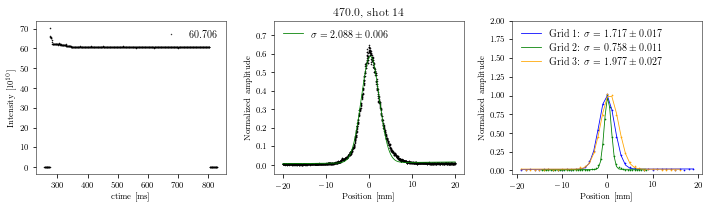

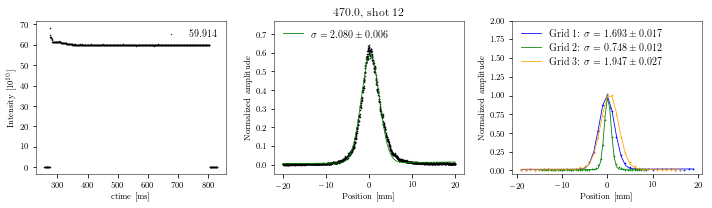

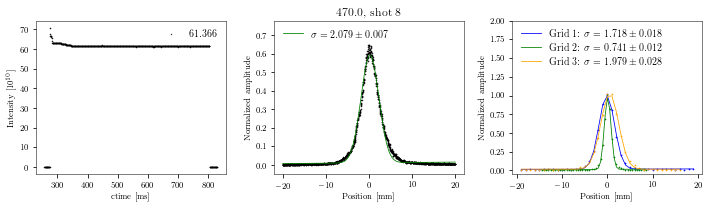

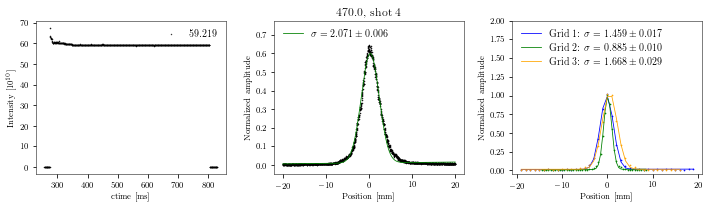

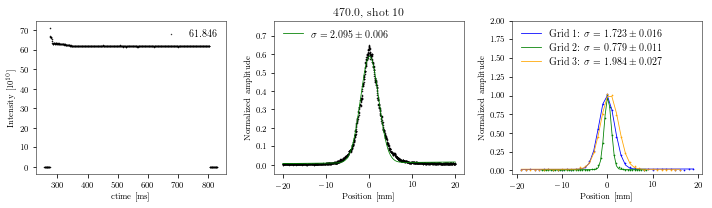

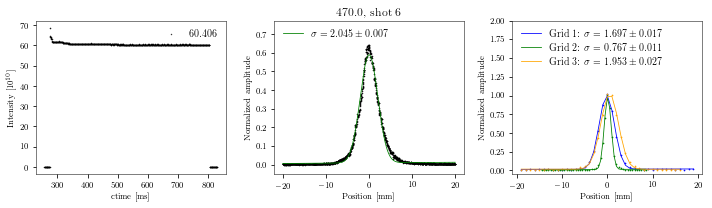

Recorded intensities: [ 60.706  59.914  61.366  59.219  61.846  60.406]
Intensities after outlier exclusion: [60.706000000000003, 59.914000000000001, 61.366, 0, 0, 60.405999999999999]
Beta wire: 4.227693716999999
Beta rel: 0.65911 Gamma rel: 1.32971
0.903402022983 60.706
0.896538401999 59.914
0.896349479066 61.366
0.888740998281 0
An intensity value was excluded.
0.910111558282 0
An intensity value was excluded.
0.866952621087 60.406

Normal emittance: [ 0.90340202  0.8965384   0.89634948  0.888741    0.91011156  0.86695262] 0.893682513616 0.013653796191
Normalized emittance: [0.60119654058038419, 0.60451574016438525, 0.59008773297303363, 0.57980548215565419] 0.593901373968 0.00973553092129
Intensity: [ 60.706  59.914  61.366  59.219  61.846  60.406]

Outliers excluded: [0.60119654058038419, 0.60451574016438525, 0.59008773297303363, 0.57980548215565419] 0.593901373968 0.00973553092129

PROFILE_TEST_340_WS_V_R3_2018_10_12_20_21


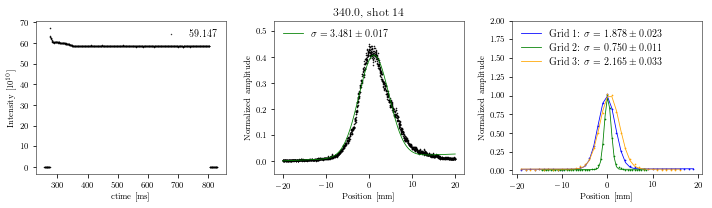

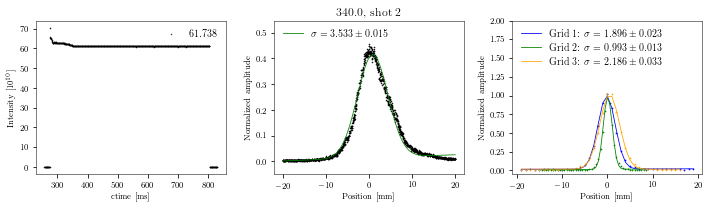

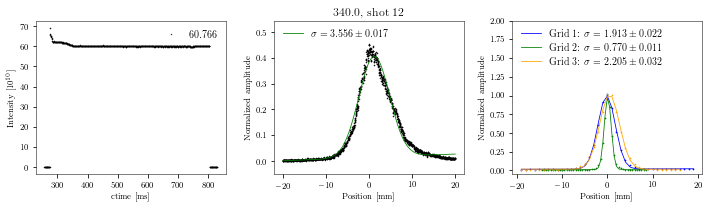

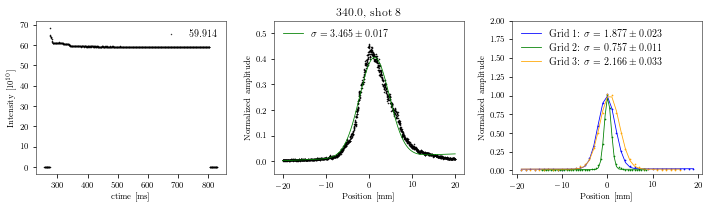

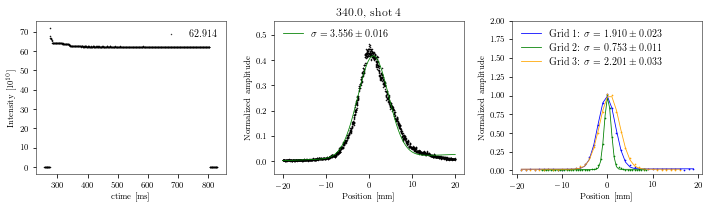

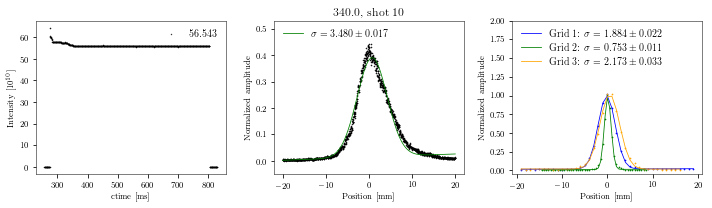

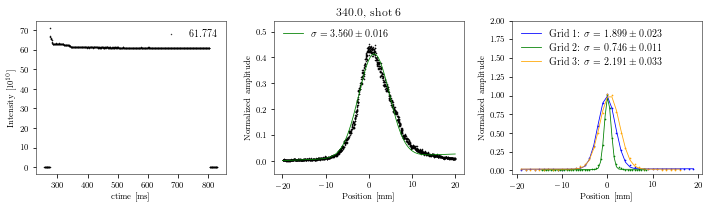

Recorded intensities: [ 59.147  61.738  60.766  59.914  62.914  56.543  61.774]
Intensities after outlier exclusion: [59.146999999999998, 61.738, 60.765999999999998, 59.914000000000001, 0, 0, 61.774000000000001]
Beta wire: 4.02490869685
Beta rel: 0.40967 Gamma rel: 1.09621
1.35188351948 59.147
1.39274574211 61.738
1.41050250556 60.766
1.33935175704 59.914
1.41070671568 0
An intensity value was excluded.
1.35101359861 0
An intensity value was excluded.
1.41398276208 61.774

Normal emittance: [ 1.35188352  1.39274574  1.41050251  1.33935176  1.41070672  1.3510136
  1.41398276] 1.38145522865 0.0303757211755
Normalized emittance: [0.99045959320548971, 0.97757366536696744, 1.0058736312425187, 0.9687161660958592, 0.99190162543120075] 0.986904936268 0.0127696347213
Intensity: [ 59.147  61.738  60.766  59.914  62.914  56.543  61.774]

Outliers excluded: [0.99045959320548971, 0.97757366536696744, 1.0058736312425187, 0.9687161660958592, 0.99190162543120075] 0.986904936268 0.0127696347213

PROFIL

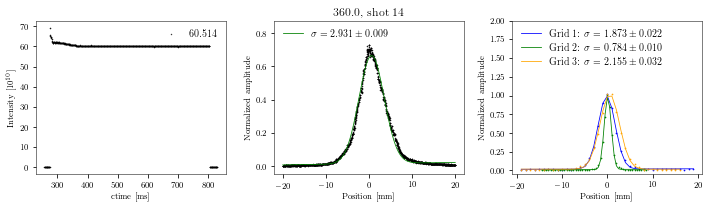

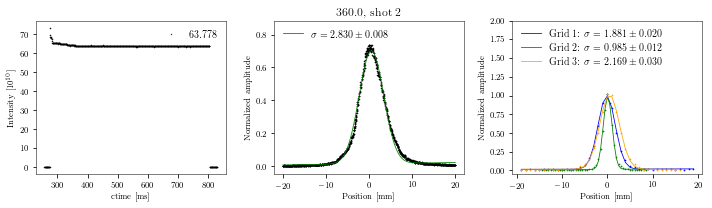

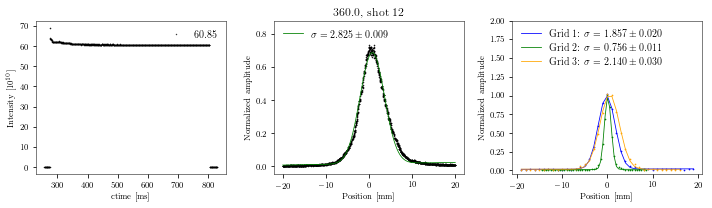

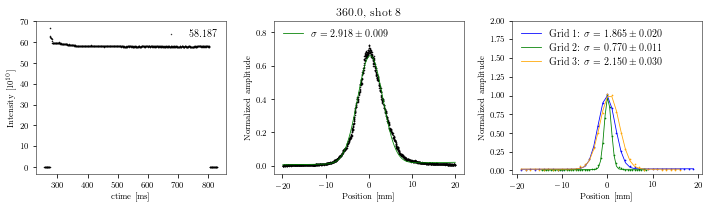

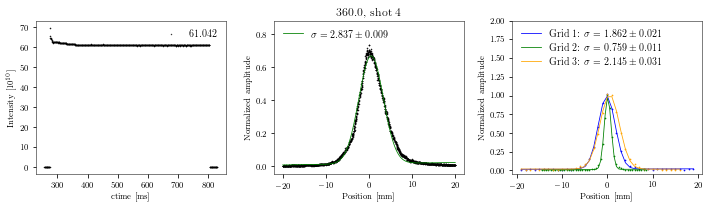

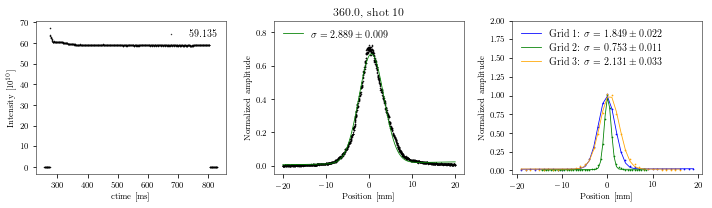

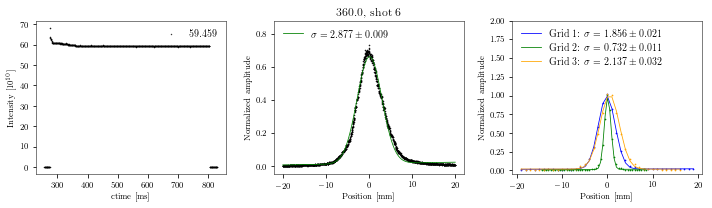

Recorded intensities: [ 60.514  63.778  60.85   58.187  61.042  59.135  59.459]
Intensities after outlier exclusion: [60.514000000000003, 0, 60.850000000000001, 0, 61.042000000000002, 59.134999999999998, 59.459000000000003]
Beta wire: 4.0722946311
Beta rel: 0.44528 Gamma rel: 1.11683
1.04932739016 60.514
0.97827365224 0
An intensity value was excluded.
0.974693724124 60.85
1.04016073118 0
An intensity value was excluded.
0.983197261261 61.042
1.01920800468 59.135
1.01099039969 59.459

Normal emittance: [ 1.04932739  0.97827365  0.97469372  1.04016073  0.98319726  1.019208
  1.0109904 ] 1.00797873762 0.0279922543228
Normalized emittance: [0.74563039588774049, 0.68877288639831946, 0.69259660945286627, 0.74111683776164494, 0.73113552509229662] 0.719850450919 0.02430145906
Intensity: [ 60.514  63.778  60.85   58.187  61.042  59.135  59.459]

Outliers excluded: [0.74563039588774049, 0.68877288639831946, 0.69259660945286627, 0.74111683776164494, 0.73113552509229662] 0.719850450919 0.02430145

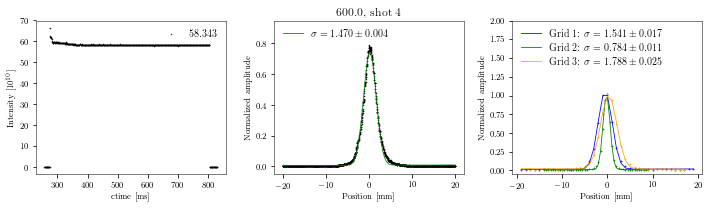

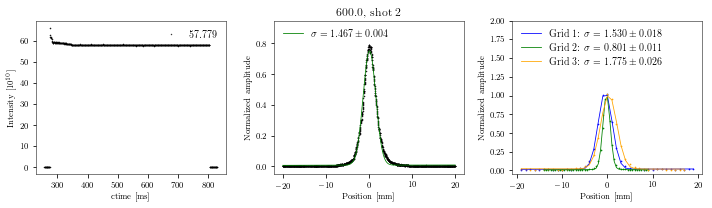

Recorded intensities: [ 58.343  57.779]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.25768796395
Beta rel: 0.84468 Gamma rel: 1.86823
0.800364777848 0
An intensity value was excluded.
0.797576033609 0
An intensity value was excluded.

Normal emittance: [ 0.80036478  0.79757603] 0.798970405728 0.00139437211974
Normalized emittance: [] nan nan
Intensity: [ 58.343  57.779]

Outliers excluded: [] nan nan

PROFILE_TEST_795_WS_V_R3_2018_10_12_18_29


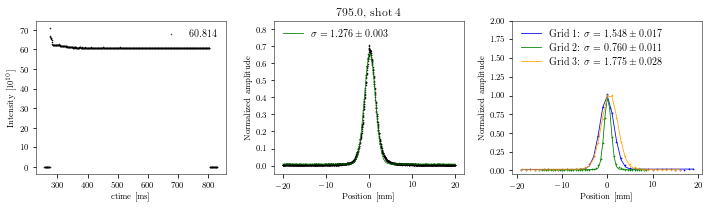

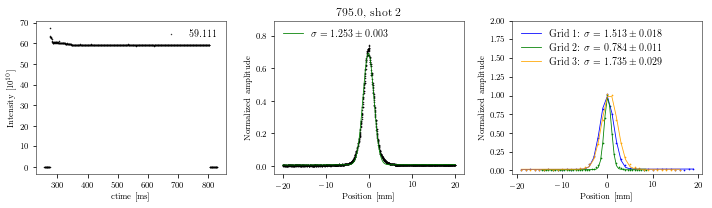

Recorded intensities: [ 60.814  59.111]
Intensities after outlier exclusion: [60.814, 0]
Beta wire: 4.2779733034
Beta rel: 0.91495 Gamma rel: 2.47794
0.863331857778 60.814
0.832155128319 0
An intensity value was excluded.

Normal emittance: [ 0.86333186  0.83215513] 0.847743493049 0.0155883647295
Normalized emittance: [0.43166592888909427] 0.431665928889 0.0
Intensity: [ 60.814  59.111]

Outliers excluded: [] nan nan

PROFILE_TEST_430_WS_V_R3_2018_10_12_20_02


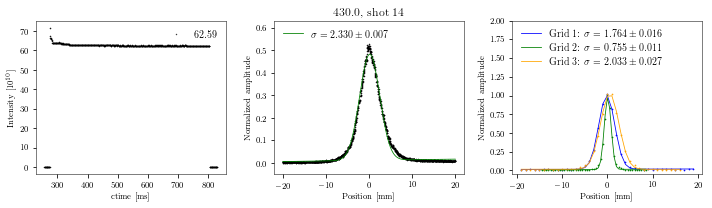

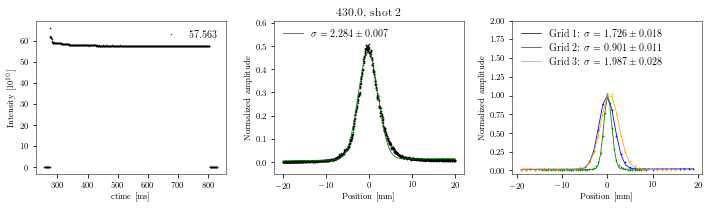

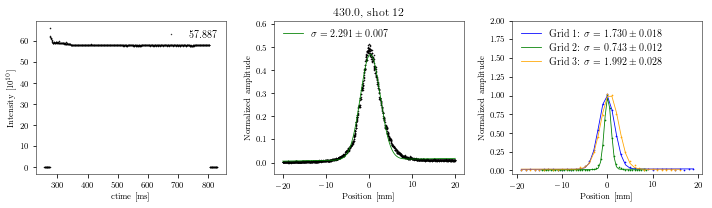

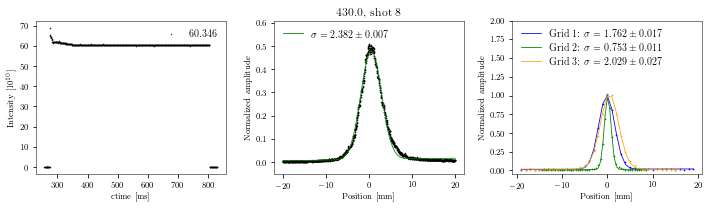

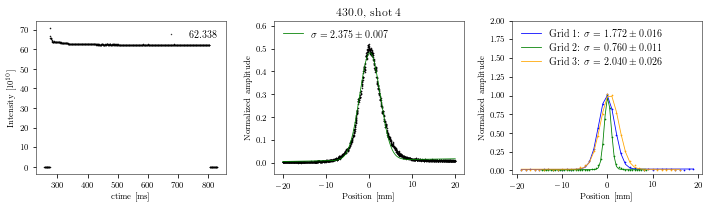

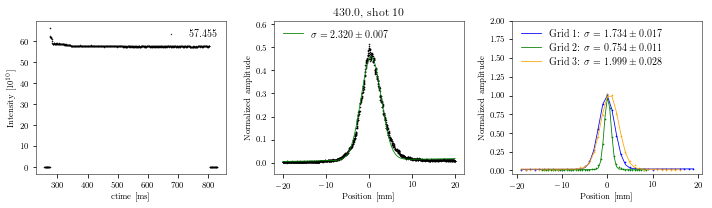

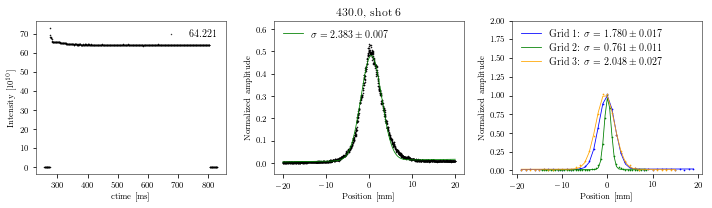

Recorded intensities: [ 62.59   57.563  57.887  60.346  62.338  57.455  64.221]
Intensities after outlier exclusion: [62.590000000000003, 0, 57.887, 60.346000000000004, 62.338000000000001, 0, 0]
Beta wire: 4.18942003405
Beta rel: 0.58113 Gamma rel: 1.22879
0.92566228528 62.59
0.888937369838 0
An intensity value was excluded.
0.894737083844 57.887
0.966889019022 60.346
0.961738839556 62.338
0.917408205311 0
An intensity value was excluded.
0.967679125655 0
An intensity value was excluded.

Normal emittance: [ 0.92566229  0.88893737  0.89473708  0.96688902  0.96173884  0.91740821
  0.96767913] 0.931864561215 0.031328936796
Normalized emittance: [0.51374013865961909, 0.53692085823483049, 0.55657541689225332, 0.53592025493554463] 0.535789167181 0.0151618414485
Intensity: [ 62.59   57.563  57.887  60.346  62.338  57.455  64.221]

Outliers excluded: [0.51374013865961909, 0.53692085823483049, 0.55657541689225332, 0.53592025493554463] 0.535789167181 0.0151618414485

PROFILE_TEST_320_WS_V_R3_20

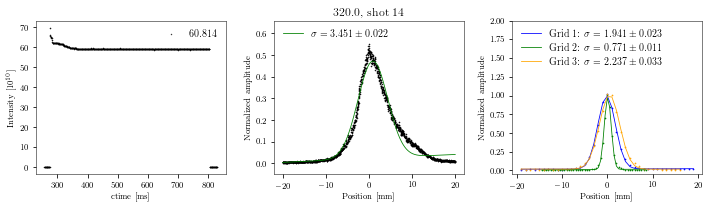

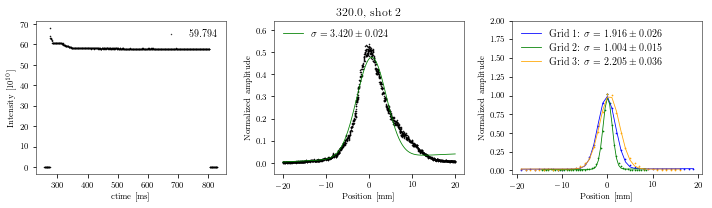

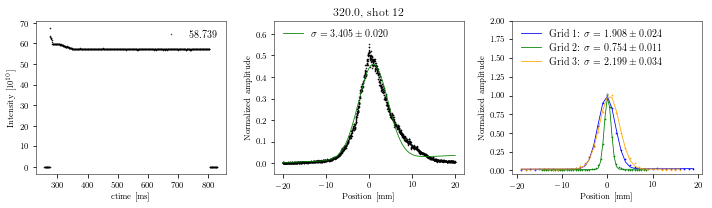

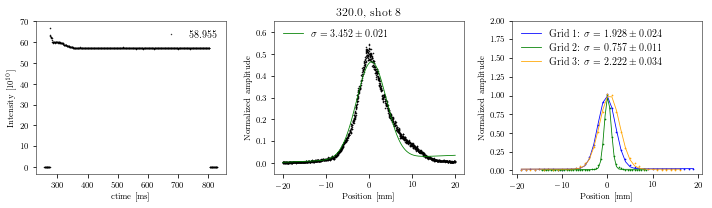

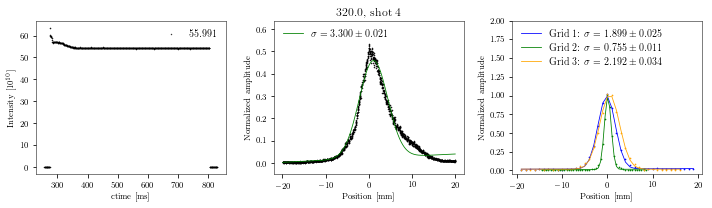

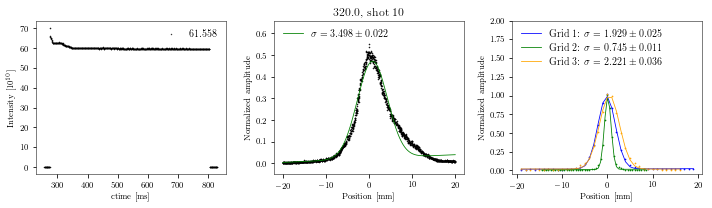

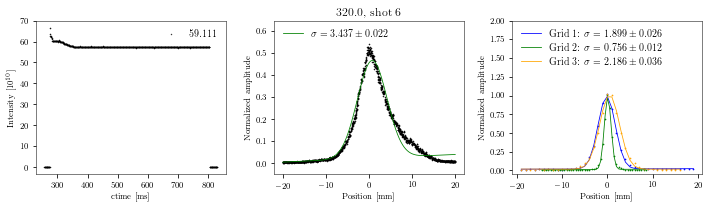

Recorded intensities: [ 60.814  59.794  58.739  58.955  55.991  61.558  59.111]
Intensities after outlier exclusion: [60.814, 59.794000000000004, 58.739000000000004, 58.954999999999998, 0, 0, 59.111000000000004]
Beta wire: 3.9732667473500003
Beta rel: 0.37581 Gamma rel: 1.0791
1.2155919732 60.814
1.19347343659 59.794
1.18368782864 58.739
1.21598318806 58.955
1.11158061816 0
An intensity value was excluded.
1.24909078507 0
An intensity value was excluded.
1.20597877047 59.111

Normal emittance: [ 1.21559197  1.19347344  1.18368783  1.21598319  1.11158062  1.24909079
  1.20597877] 1.19648380003 0.0396130339617
Normalized emittance: [0.84927074011545056, 0.84804140691804741, 0.85619471166432914, 0.8763323307380475, 0.86682866389970148] 0.859333570667 0.0108051860067
Intensity: [ 60.814  59.794  58.739  58.955  55.991  61.558  59.111]

Outliers excluded: [0.84927074011545056, 0.84804140691804741, 0.85619471166432914, 0.8763323307380475, 0.86682866389970148] 0.859333570667 0.0108051860067



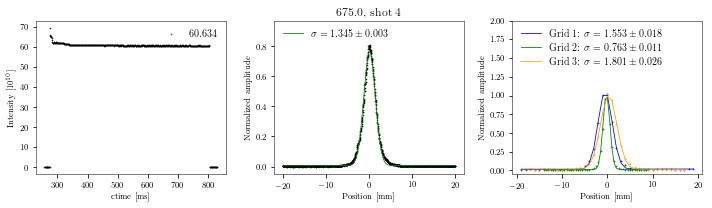

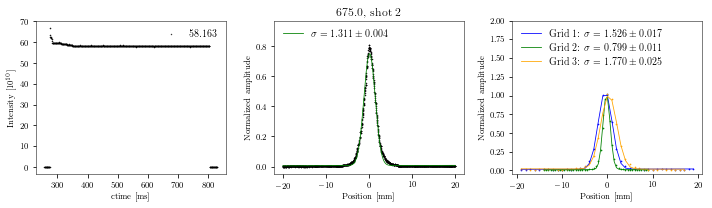

Recorded intensities: [ 60.634  58.163]
Intensities after outlier exclusion: [0, 58.163000000000004]
Beta wire: 4.2726342777
Beta rel: 0.89503 Gamma rel: 2.24208
0.849325590674 0
An intensity value was excluded.
0.80770611963 58.163

Normal emittance: [ 0.84932559  0.80770612] 0.828515855152 0.0208097355218
Normalized emittance: [0.4038530598151745] 0.403853059815 0.0
Intensity: [ 60.634  58.163]

Outliers excluded: [] nan nan

PROFILE_TEST_500_WS_V_R3_2018_10_12_17_51


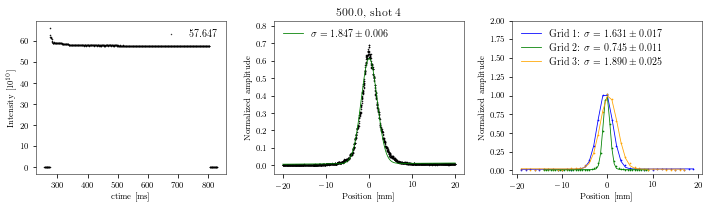

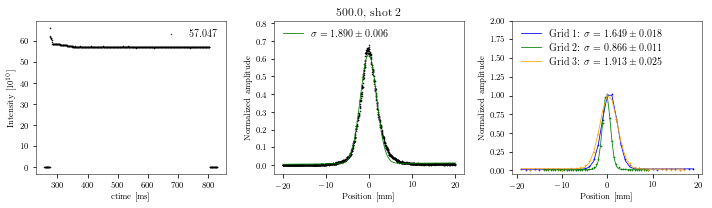

Recorded intensities: [ 57.647  57.047]
Intensities after outlier exclusion: [0, 0]
Beta wire: 4.23693087795
Beta rel: 0.71309 Gamma rel: 1.42638
0.818775456121 0
An intensity value was excluded.
0.857654342247 0
An intensity value was excluded.

Normal emittance: [ 0.81877546  0.85765434] 0.838214899184 0.0194394430633
Normalized emittance: [] nan nan
Intensity: [ 57.647  57.047]

Outliers excluded: [] nan nan

PROFILE_TEST_285_WS_V_R3_2018_10_12_16_43


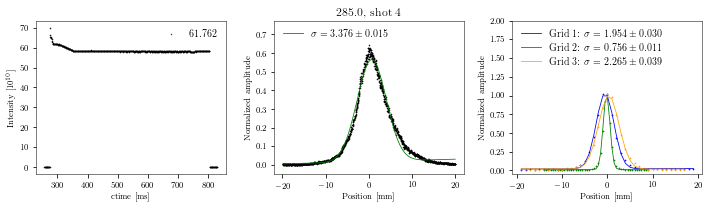

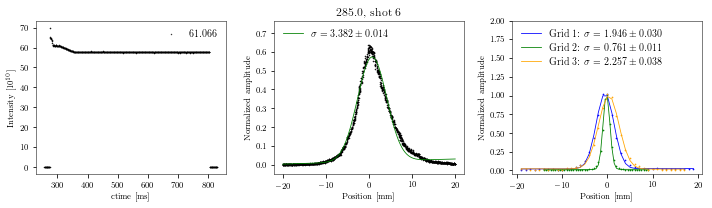

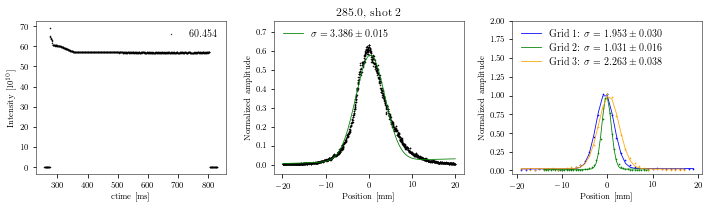

Recorded intensities: [ 61.762  61.066  60.454]
Intensities after outlier exclusion: [0, 61.066000000000003, 0]
Beta wire: 3.8624470797
Beta rel: 0.32403 Gamma rel: 1.05703
1.01052262246 0
An intensity value was excluded.
1.01426044711 61.066
1.01666064058 0
An intensity value was excluded.

Normal emittance: [ 1.01052262  1.01426045  1.01666064] 1.01381457005 0.00252559186142
Normalized emittance: [0.33808681570194676] 0.338086815702 0.0
Intensity: [ 61.762  61.066  60.454]

Outliers excluded: [] nan nan

PROFILE_TEST_325_WS_V_R3_2018_10_12_17_16


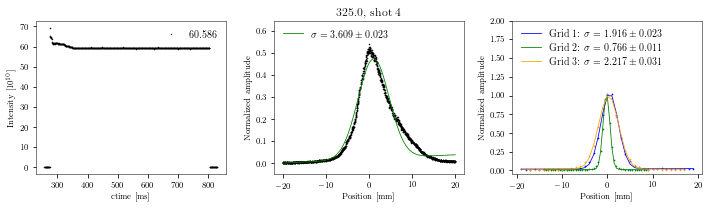

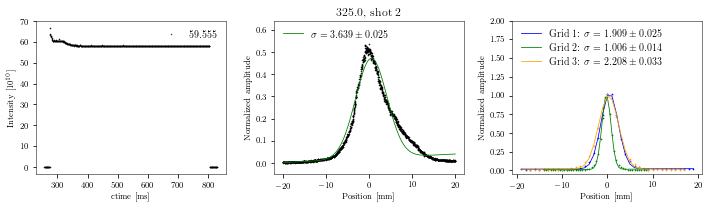

Recorded intensities: [ 60.586  59.555]
Intensities after outlier exclusion: [0, 59.555]
Beta wire: 3.9867574309
Beta rel: 0.38404 Gamma rel: 1.08305
1.35876935003 0
An intensity value was excluded.
1.381630866 59.555

Normal emittance: [ 1.35876935  1.38163087] 1.37020010801 0.0114307579864
Normalized emittance: [0.69081543299931492] 0.690815432999 0.0
Intensity: [ 60.586  59.555]

Outliers excluded: [] nan nan


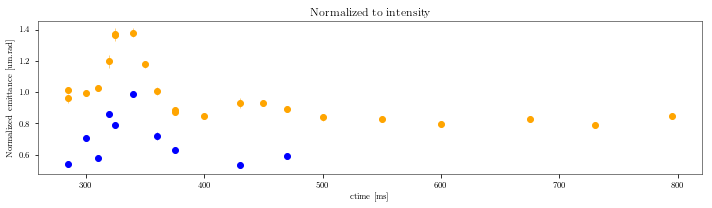

In [5]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('TEST_(.*)_WS', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
plt.title("Normalized to intensity")
# plt.show()

plt.errorbar(ctime, emittance, yerr=error, fmt='o', color="orange")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

# plt.scatter(ctime, gamma_rel)
# plt.scatter(ctime, beta_rel)
# plt.xlabel("ctime [ms]")
# plt.ylabel("Normalized emittance [um.rad]")
# plt.show()

plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.